In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pulsar_data_train.csv')
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [ ]:
colu = ['mean_ip',
       'standard_ip',
       'excess_ip',
       'skewness_ip', 'mean_DM_SNR',
       'standard_DM_SNR',
       'exces_DM_SNR', 'skewness_DM_SNR',
       'target_class']
df.columns = colu
df['target_class'].value_counts()

0.0    11375
1.0     1153
Name: target_class, dtype: int64

In [ ]:
for col in df:
    col_median=df[col].median()
    df[col].fillna(col_median, inplace=True)


In [ ]:
X_train = np.array(df.drop('target_class', 1))
y_train = np.array(df['target_class'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)

X_train.shape (10022, 8)
y_train.shape (10022,)
X_test.shape (2506, 8)


<ipython-input-199-11c8d200c8e6>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = np.array(df.drop('target_class', 1))


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [ ]:
scaler.mean_

array([111.08688074,  46.52171856,   0.44432153,   1.78899457,
        12.52410825,  25.57774587,   8.33498968, 104.35025042])

In [ ]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = colu[:-1])
X_train_scaled.head()

,mean_ip,standard_ip,excess_ip,skewness_ip,mean_DM_SNR,standard_DM_SNR,exces_DM_SNR,skewness_DM_SNR
0,0.404384,0.205388,-0.220420,-0.330106,-0.382402,-0.676406,1.124968,1.004101
1,0.267858,-0.071088,-0.291275,-0.247020,-0.361372,-0.679120,0.495730,0.466186
2,1.734147,-0.985417,-0.751485,-0.105300,-0.240312,0.244681,-0.532280,-0.653361
3,1.604296,0.759860,-1.461018,-0.176267,5.059506,3.812575,-2.023116,-1.005501
4,0.038191,0.605514,-0.185625,-0.312212,-0.340656,-0.531498,0.018356,-0.148834


In [ ]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = colu[:-1])
X_test_scaled.head()

,mean_ip,standard_ip,excess_ip,skewness_ip,mean_DM_SNR,standard_DM_SNR,exces_DM_SNR,skewness_DM_SNR
0,0.210820,1.088225,-0.279843,-0.382428,-0.368067,-0.655038,0.509006,0.400642
1,0.765723,-0.164303,-0.220420,-0.257603,-0.360113,-0.472739,0.565040,0.254126
2,-0.794011,-1.591453,0.077120,0.120089,-0.362888,-0.432591,0.513824,0.182500
3,0.314580,0.436175,-0.501191,-0.328475,-0.189868,0.306148,-0.728192,-0.744392
4,0.048809,1.716643,-0.007635,-0.328195,-0.350499,-0.402357,0.195840,-0.099168


In [ ]:
%%time
# Веса всех нейронов
x0 = np.random.normal(size=(8, 2)) / np.sqrt(8)
neurons = torch.tensor(x0, requires_grad=True)

# Конвертируем датасет в читаемый торчом формат
X = torch.tensor(X_train_scaled.values)
y = torch.tensor(y_train, dtype=torch.long)
# SGD
optimizer = torch.optim.SGD(params=[neurons], lr=1)

loss_history = []

# 100 шагов
for i in range(65):
    # считаем произведение матрицы параметров на матрицу (из 10 нейронов) весов
    predictions = X @ neurons
    # Вычисляем loss
    loss = torch.nn.functional.cross_entropy(predictions, y) # функция активации уже включена
    # Вычисляем градиент
    optimizer.zero_grad()
    loss.backward()
    # Делаем шаг
    optimizer.step()
    # логируем loss
    loss_history.append(loss.data.numpy())

CPU times: user 163 ms, sys: 3.51 ms, total: 167 ms
Wall time: 171 ms


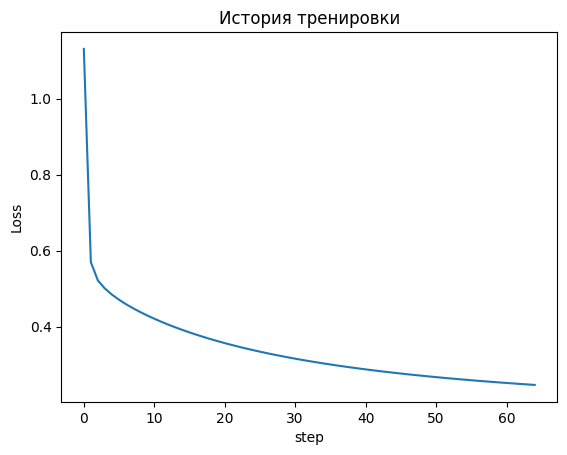

In [ ]:
plt.title('История тренировки')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(loss_history);

In [ ]:
# Тот же код для метрик качества
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

digit_probabilities = sigmoid((X @ neurons).data.numpy())
print('digit_probabilities.shape:', digit_probabilities.shape)
# Находим вероятности на test

from sklearn.metrics import f1_score

# Максимум
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('\nTrain f1:', f1_score(y_train, predictions, average='macro'))

digit_probabilities.shape: (10022, 2)
predictions.shape: (10022,)

Train f1: 0.8636460444469563


In [ ]:
# Будет использовать высокоуровневый API torch: nn
# Когда мы создаем нейронную сеть в pytorch, мы обычно создаем класс, который происходит от torch.nn.Module
# Это легко обучить и в дальнейшем использовать сеть, определенную таким образом
# Эта сеть имеет 210 нейронов
import torch.nn.functional as F

class MyFirstNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        super().__init__()
        # Здесь мы определяем обучаемые параметры модели
        # Первый слой весов
        # init_1 = np.random.normal(size=(784, n_hidden_neurons)) / np.sqrt(784) # гуглите "xavier initialization"
        # self.neurons_layer1 = torch.tensor(init_1, requires_grad=True) # веса для первого слоя нейронов
        # self.neurons_layer1 = nn.Parameter(self.neurons_layer1)
        self.neurons_layer1 = nn.Linear(8, n_hidden_neurons)

        # веса для второго слоя нейронов
        # init_2 = np.random.normal(size=(n_hidden_neurons, 10)) / np.sqrt(n_hidden_neurons)
        # self.neurons_layer2 = torch.tensor(init_2, requires_grad=True)
        # self.neurons_layer2 = nn.Parameter(self.neurons_layer2)
        self.neurons_layer2 = nn.Linear(n_hidden_neurons, 2)

    def forward(self, x):
        # Здесь мы делаем все вычисления
        # Первый слой
        # h = x @ self.neurons_layer1
        h = self.neurons_layer1(x)
        # Функция активации скрытого слоя
        # h = torch.relu(h)
        h = F.relu(h)

        # Выходной слой
        # out = h @ self.neurons_layer2
        out = self.neurons_layer2(h)
        return out

In [ ]:
import numpy as np

model = MyFirstNN()
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

N_EPOCHS = 50

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_dev = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_dev = torch.tensor(y_test, dtype=torch.long)

train_loss_history = []
dev_loss_history = []

# Пройдемся 50 эпох
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = torch.nn.functional.cross_entropy(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())

    # Валидируемся
    if i % 10 == 0:
        predictions = model(X_dev)
        loss = torch.nn.functional.cross_entropy(predictions, y_dev)
        dev_loss_history.append(loss.item())


100%|██████████| 50/50 [00:01<00:00, 30.39it/s]


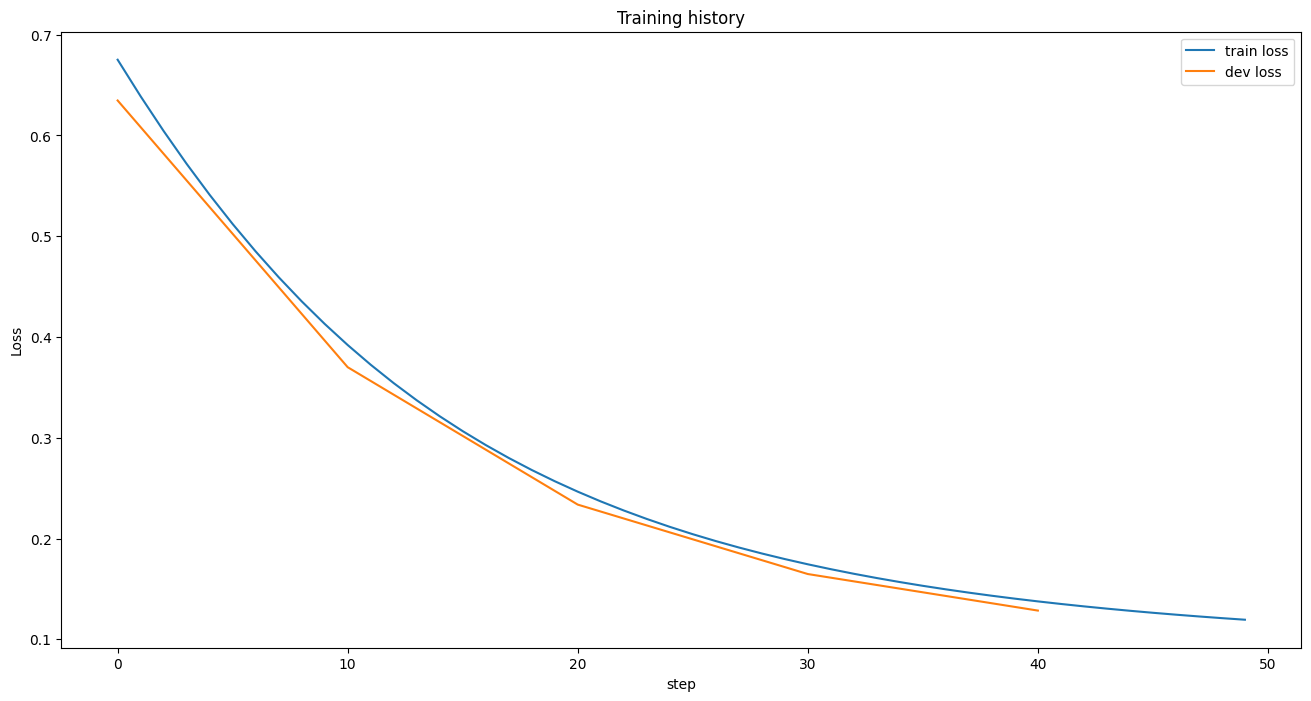

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train loss')
plt.plot(range(N_EPOCHS)[::10], dev_loss_history, label='dev loss')
plt.legend();

In [ ]:
# Метрики качества
digit_probabilities = model(X_dev).detach().numpy()
print('digit_probabilities.shape:', digit_probabilities.shape)
# Нашли вероятности принадлежности семплов test-а

from sklearn.metrics import classification_report

# Округлили
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('test results:')
print(classification_report(y_dev.detach().cpu().numpy(), predictions))

digit_probabilities.shape: (2506, 2)
predictions.shape: (2506,)
test results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2279
           1       0.96      0.75      0.84       227

    accuracy                           0.97      2506
   macro avg       0.97      0.87      0.91      2506
weighted avg       0.97      0.97      0.97      2506



In [ ]:
from torch.nn import ReLU
import torch.nn.functional as F

class MySecondNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        # super позволяеть наследовать методы модуля nn
        super(MySecondNN,self).__init__()
        # создаем линейный слой
        self.linear1 = nn.Linear(8,2)
        self.linear2 = nn.Linear(2,n_hidden_neurons)
        self.linear3 = nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.linear4 = nn.Linear(n_hidden_neurons,2)
        self.ReLU = nn.ReLU(inplace=True)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

import numpy as np

model = MySecondNN()
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
N_EPOCHS = 100

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_dev = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_dev = torch.tensor(y_test, dtype=torch.long)

train_loss_history = []
dev_loss_history = []
ce = nn.CrossEntropyLoss()

# Пройдемся 501 эпоху
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = ce(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())

    if i % 10 == 0:
       predictions = model(X_dev)
       loss = ce(predictions, y_dev)
       dev_loss_history.append(loss.item())


100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


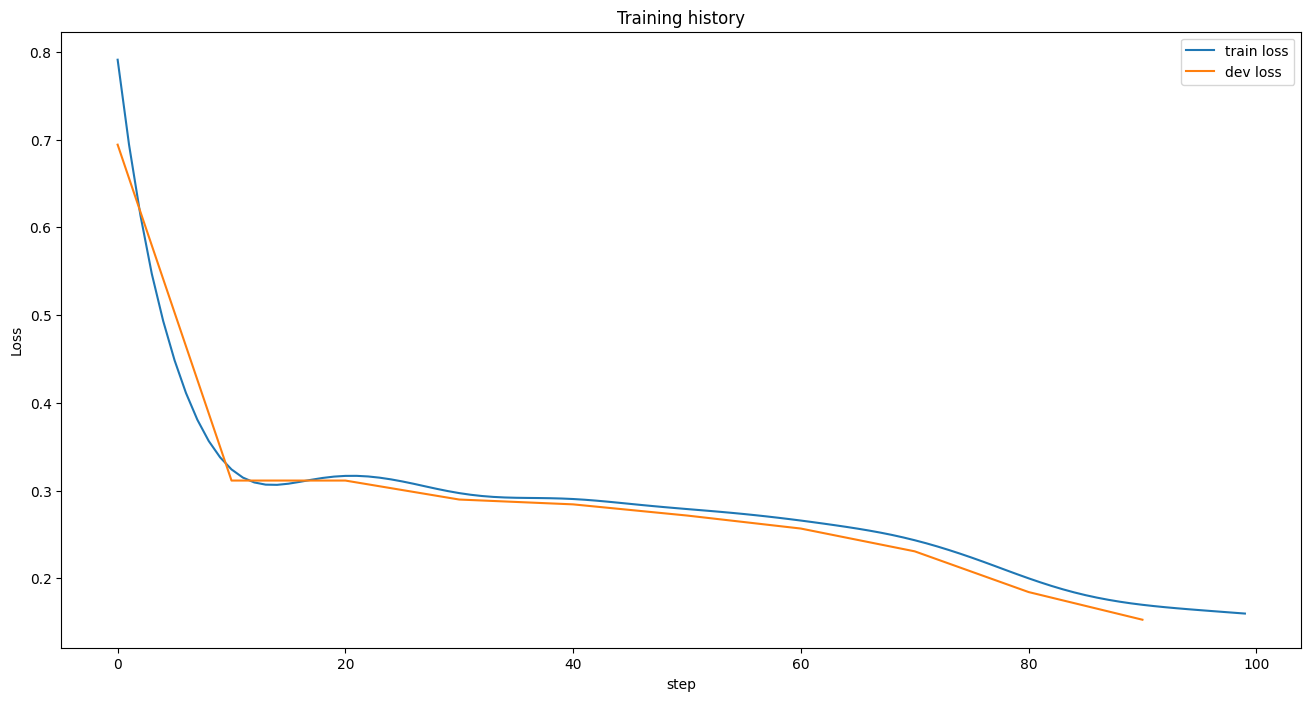

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train loss')
plt.plot(range(N_EPOCHS)[::10], dev_loss_history, label='dev loss')
plt.legend();

In [ ]:
digit_probabilities = model(X_dev).detach().numpy()
print('digit_probabilities.shape:', digit_probabilities.shape)

from sklearn.metrics import classification_report

predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('test results:')
print(classification_report(y_dev.detach().cpu().numpy(), predictions))

digit_probabilities.shape: (2506, 2)
predictions.shape: (2506,)
test results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2279
           1       0.83      0.63      0.71       227

    accuracy                           0.95      2506
   macro avg       0.89      0.81      0.84      2506
weighted avg       0.95      0.95      0.95      2506



In [309]:
X_tr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_dev = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_dev = torch.tensor(y_test, dtype=torch.long)

In [310]:
X_tr.shape, y_tr.shape

(torch.Size([10022, 8]), torch.Size([10022]))

In [311]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [312]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

# class SimpleNet(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.flatten = Flatten()
#     self.fc1 = nn.Linear(8, 4)
#     self.fc2 = nn.Linear(4,1)

#   def forward(self, x):
#     x = self.flatten(x)
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))


In [313]:
from tqdm.notebook import tqdm

In [314]:
from sklearn.metrics import accuracy_score

In [384]:
def train(net, n_epoch=5):

    loss_fn = torch.nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    best_accuracy = 0

    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0

        for i, batch in enumerate(X_tr):

            X_batch, y_batch = batch, y_tr[i]

            optimizer.zero_grad()

            y_pred = net(X_batch)

            loss = loss_fn(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0


        with torch.no_grad():
            accuracy = []
            for i, batch in enumerate(X_dev):
                x, y = batch, y_dev[i]
                y_pred = net(x)

                accuracy.append(accuracy_score(y.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))


            accuracy_1 = np.mean(np.array(accuracy))

            if accuracy_1 > best_accuracy:
                print('New best model with test acc:', accuracy)
                torch.save(net.state_dict(), './best_model.pt')
                best_accuracy = accuracy_1

    print('Обучение закончено')
    return net

In [385]:
model = nn.Sequential(
    nn.Linear(8, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

In [386]:
model = train(model)

  0%|          | 0/5 [00:00<?, ?it/s]

[1,   500] loss: 0.324
[1,  1000] loss: 0.148
[1,  1500] loss: 0.091
[1,  2000] loss: 0.125
[1,  2500] loss: 0.084
[1,  3000] loss: 0.071
[1,  3500] loss: 0.088
[1,  4000] loss: 0.141
[1,  4500] loss: 0.062
[1,  5000] loss: 0.070
[1,  5500] loss: 0.080
[1,  6000] loss: 0.149
[1,  6500] loss: 0.112
[1,  7000] loss: 0.100
[1,  7500] loss: 0.104
[1,  8000] loss: 0.047
[1,  8500] loss: 0.112
[1,  9000] loss: 0.080
[1,  9500] loss: 0.044
[1, 10000] loss: 0.089


AxisError: ignored